In [ ]:

""" This notebook mainly includes "Classification plots in time".
- Label = 1 if |next-day log return| >= k * rolling_std_20 (computed at t)
- Features: mentions (levels & 1-day changes, if present), recent return stats, rolling std, variance controls
- Models: Logistic Regression & RandomForest trained on SMOTE-resampled training data
- Robust to missing mention columns (fills with 0).
"""

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, confusion_matrix, f1_score)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


In [2]:



ROLL_WIN = int(os.getenv("ROLL_WIN", 20))   # rolling window for volatility
K_SIGMA  = float(os.getenv("K_SIGMA", 1.5)) # threshold multiplier

DATA_DIR = Path(os.getenv("DATA_DIR", "/users/nihan/Desktop/Erdos_FinanceProject/classification"))
DATA_STOCK    = DATA_DIR / os.getenv("DATA_STOCK", "bluesky_stock_merged.csv")
DATA_MENTIONS = DATA_DIR / os.getenv("DATA_MENTIONS", "bluesky_merged_mentions.csv")
DATA_CONTROLS = DATA_DIR / os.getenv("DATA_CONTROLS", "control_sa.csv")

OUT_DATASET = DATA_DIR / "movement_threshold_dataset_smote_xgb.csv"
OUT_RESULTS = DATA_DIR / "model_results_smote_xgb.csv"
OUT_ROC_PNG = DATA_DIR / "roc_comparison_smote_xgb.png"

MENTION_COLS = ["all_keywords_mentions","ticker_mentions","ceo_mentions"]


In [3]:

def safe_read_csv(path: Path) -> pd.DataFrame:
    if path.exists():
        return pd.read_csv(path)
    print(f"[WARN] Missing file: {path} — continuing without it.")
    return pd.DataFrame()

def ensure_mention_cols(df: pd.DataFrame) -> pd.DataFrame:
    for c in MENTION_COLS:
        if c not in df.columns:
            df[c] = 0
    return df

def build_dataset():
    stock = safe_read_csv(DATA_STOCK)
    assert not stock.empty, f"Cannot proceed: {DATA_STOCK} is missing or empty."
    stock["Date"] = pd.to_datetime(stock["Date"])

    mentions = safe_read_csv(DATA_MENTIONS)
    if not mentions.empty:
        if "date" in mentions.columns:
            mentions["date"] = pd.to_datetime(mentions["date"])
            mentions = mentions.rename(columns={"date": "Date"})
        elif "Date" in mentions.columns:
            mentions["Date"] = pd.to_datetime(mentions["Date"])
        else:
            print("[WARN] Mentions has no date column; skipping merge.")
            mentions = pd.DataFrame()

    controls = safe_read_csv(DATA_CONTROLS)

    df = stock.copy()
    if not mentions.empty and {"company","Date"}.issubset(mentions.columns) and "company" in df.columns:
        keep = ["company","Date"] + [c for c in MENTION_COLS if c in mentions.columns]
        keep = [c for c in keep if c in mentions.columns]
        df = df.merge(mentions[keep], on=["company","Date"], how="left")
    else:
        print("[INFO] Mentions merge skipped or partial; filling missing mention columns with zeros.")
    df = ensure_mention_cols(df)

    if not controls.empty and "Ticker" in controls.columns:
        df = df.merge(controls, on="Ticker", how="left", suffixes=("","_ctrl"))

    # Target construction
    df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)
    df["log_ret_t"]   = df["log_return"]
    df["log_ret_tp1"] = df.groupby("Ticker")["log_return"].shift(-1)
    df["roll_std_20"] = df.groupby("Ticker")["log_ret_t"].transform(
        lambda s: s.rolling(ROLL_WIN, min_periods=20).std()
    )
    df["label_big_move"] = (df["log_ret_tp1"].abs() >= (K_SIGMA * df["roll_std_20"])).astype(int)

    # Feature engineering
    for col in MENTION_COLS:
        df[f"{col}_lag1"] = df.groupby("Ticker")[col].shift(1)
        df[f"{col}_chg1"]  = df[col] - df[f"{col}_lag1"]

    df["ret_lag1"] = df.groupby("Ticker")["log_ret_t"].shift(1)
    df["ret_lag5"] = df.groupby("Ticker")["log_ret_t"].shift(5)
    df["ret_ma5"]  = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).mean())
    df["ret_std5"] = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).std())

    df_model = df.dropna(subset=["log_ret_tp1","roll_std_20"]).copy()

    candidate_feats = [
        "all_keywords_mentions","ticker_mentions","ceo_mentions",
        "all_keywords_mentions_chg1","ticker_mentions_chg1","ceo_mentions_chg1",
        "ret_lag1","ret_lag5","ret_ma5","ret_std5",
        "roll_std_20",
        "weekly_variance","monthly_variance",
        "weekly_variance_ctrl","pct_change","monthly_variance_ctrl"
    ]
    feature_cols = [c for c in candidate_feats if c in df_model.columns]

    return df_model, feature_cols



In [4]:
    df_model, feature_cols = build_dataset()

    X = df_model[feature_cols].copy()
    y = df_model["label_big_move"].astype(int).copy()

In [5]:
# ===  Time-based comparison AFTER cutoff (per-model) ===
# Builds test split from df_model, scores available models, and plots:
# 1) Daily mean predicted probability (7d rolling) vs actual daily spike rate
# 2) Test ROC-AUC bar chart per model
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ---- Recreate the same 80/20 time split your main code uses ----
assert {"Date","Ticker","label_big_move"}.issubset(df_model.columns), "df_model missing required columns"
assert isinstance(feature_cols, (list, tuple)) and len(feature_cols) > 0, "feature_cols not set"

cutoff_date = df_model["Date"].quantile(0.80)
mask_tr = df_model["Date"] <= cutoff_date
mask_te = df_model["Date"] >  cutoff_date

X_train = df_model.loc[mask_tr, feature_cols]
y_train = df_model.loc[mask_tr, "label_big_move"].astype(int)
X_test  = df_model.loc[mask_te,  feature_cols]
y_test  = df_model.loc[mask_te,  "label_big_move"].astype(int)
test_meta = df_model.loc[mask_te, ["Date","Ticker"]].reset_index(drop=True)



In [8]:

# ---- without changing hyperparams/pipelines ----
models = []
if "logit" in globals(): models.append(("Logistic", logit))
if "rf"    in globals(): models.append(("RandomForest", rf))
if "xgb"   in globals(): models.append(("XGBoost", xgb))
if "extra" in globals(): models.append(("ExtraTrees", extra))


In [27]:
logit = SkPipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_split=4,
    min_samples_leaf=2, n_jobs=-1, class_weight="balanced_subsample",
    random_state=42
)

xgb = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42, use_label_encoder=False
)

extra = ExtraTreesClassifier(n_estimators=400, random_state=42
)


logit.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
extra.fit(X_train, y_train)


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [28]:

# --- Verify models are fitted; do NOT refit here ---
def _assert_fitted(name, mdl):
    base = mdl.named_steps["clf"] if hasattr(mdl, "named_steps") else mdl
    assert hasattr(base, "predict_proba"), f"{name} not fitted yet – run main() first."
    return mdl

models = [
    ("Logistic", _assert_fitted("Logistic", logit)),
    ("RandomForest", _assert_fitted("RandomForest", rf)),
    ("XGBoost", xgb) if "xgb" in globals() else None,
    ("ExtraTrees", extra) if "extra" in globals() else None,
]
models = [m for m in models if m]


In [30]:
# --- Helper: ensure model is fitted (no refit) ---
def _ensure_fitted(name, mdl):
    """
    Check that a model has been fitted. If not, raise a clear message.
    """
    base = None
    if hasattr(mdl, "named_steps"):
        for k in ("clf","model","estimator"):
            if k in mdl.named_steps:
                base = mdl.named_steps[k]; break
    base = base or mdl
    fitted = hasattr(base, "classes_") or hasattr(base, "coef_") or hasattr(base, "feature_importances_")
    assert fitted, f"{name} not fitted yet — please run your main training cell first."
    return mdl


In [68]:
# === Safe scoring + plots (no refit) ===
# Rebuild test split, score any fitted models, and plot AUC + time series

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ---- df_model & feature_cols must exist ----
assert "df_model" in globals() and "feature_cols" in globals(), "Run build_dataset() first."


def _is_fitted(m):
    base = m.named_steps.get("clf") if hasattr(m, "named_steps") and "clf" in m.named_steps else m
    return any(hasattr(base, attr) for attr in ("classes_","coef_","feature_importances_"))

def _predict_proba(m, X):
    # pipeline uses its own transform; bare estimator expects raw X
    if hasattr(m, "predict_proba"):
        return m.predict_proba(X)[:, 1]
    if hasattr(m, "decision_function"):
        s = m.decision_function(X).astype(float)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    raise ValueError("Model has neither predict_proba nor decision_function.")

# ---Score test set ----
probs, auc_rows = {}, []
for name, mdl in usable:
        p = _predict_proba(mdl, X_test)
        probs[name] = p
        auc = float(roc_auc_score(y_test, p)) if y_test.nunique() > 1 else np.nan
        auc_rows.append({"Model": name, "AUC_test": auc})




In [69]:

# ---- AUC table ----
auc_df = pd.DataFrame(auc_rows).sort_values("AUC_test", ascending=False, na_position="last").reset_index(drop=True)
display(auc_df.round(4))


,Model,AUC_test
0,RandomForest,0.6703
1,XGBoost,0.6614
2,ExtraTrees,0.6532
3,Logistic,0.6431


In [74]:

# ---- Build time-series frame for the TEST period only ----
ts = test_meta.copy()
ts["y"] = y_test.values
for name, p in probs.items():
    ts[name] = p
ts.head(5)

,Date,Ticker,y,Logistic,RandomForest,XGBoost,ExtraTrees
0,2025-05-22,AAPL,1,0.339003,0.069804,0.033232,0.0550
1,2025-05-23,AAPL,0,0.361601,0.096474,0.041541,0.1000
2,2025-05-27,AAPL,0,0.321768,0.154561,0.135194,0.1275
3,2025-05-28,AAPL,0,0.388503,0.120674,0.134208,0.1000
4,2025-05-29,AAPL,0,0.340035,0.253621,0.192306,0.1650


In [75]:

# Daily cross-sectional means per model + actual event rate
daily = (ts.groupby("Date")
            .agg({**{k: "mean" for k in probs.keys()}, **{"y": "mean"}})
            .reset_index())
daily.head(5)

,Date,Logistic,RandomForest,XGBoost,ExtraTrees,y
0,2025-05-22,0.476517,0.221527,0.213404,0.215500,0.111111
1,2025-05-23,0.494955,0.190232,0.145885,0.179889,0.155556
2,2025-05-27,0.483835,0.200135,0.143356,0.180500,0.000000
3,2025-05-28,0.509007,0.186441,0.138216,0.190667,0.044444
4,2025-05-29,0.473075,0.202366,0.181636,0.198889,0.066667


In [76]:

# 7-day rolling smoothing for readability
roll = daily.copy()
for name in probs.keys():
    roll[name] = roll[name].rolling(7, min_periods=1).mean()
roll["y"] = roll["y"].rolling(7, min_periods=1).mean()
roll.head(5)

,Date,Logistic,RandomForest,XGBoost,ExtraTrees,y
0,2025-05-22,0.476517,0.221527,0.213404,0.215500,0.111111
1,2025-05-23,0.485736,0.205880,0.179645,0.197694,0.133333
2,2025-05-27,0.485102,0.203965,0.167549,0.191963,0.088889
3,2025-05-28,0.491079,0.199584,0.160216,0.191639,0.077778
4,2025-05-29,0.487478,0.200140,0.164500,0.193089,0.075556


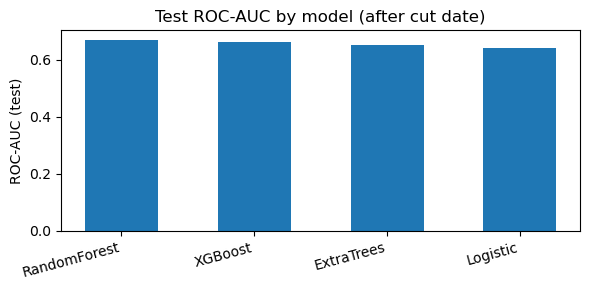

In [77]:

# ---- Plot: Test ROC-AUC bar chart  ----
plt.figure(figsize=(6, 3))
x = np.arange(len(auc_df))
plt.bar(x, auc_df["AUC_test"].values, width=0.55)
plt.xticks(x, auc_df["Model"].values, rotation=15, ha="right")
plt.ylabel("ROC-AUC (test)")
plt.title("Test ROC-AUC by model (after cut date)")
plt.tight_layout(); plt.show()


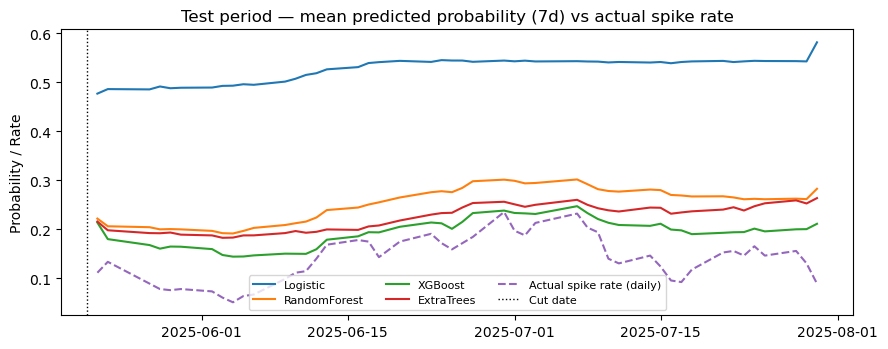

In [78]:

# ---- Plot: Daily mean predicted probability vs actual spike rate (7d roll) ----
plt.figure(figsize=(9, 3.6))
for name in probs.keys():
    plt.plot(roll["Date"], roll[name], label=name)
plt.plot(roll["Date"], roll["y"], linestyle="--", label="Actual spike rate (daily)")
plt.axvline(pd.to_datetime(cutoff_date), color="k", ls=":", lw=1, label="Cut date")
plt.ylabel("Probability / Rate")
plt.title("Test period — mean predicted probability (7d) vs actual spike rate")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout(); plt.show()


In [79]:
# Check class balance in the TRAIN and TEST slices used by the add-on cell
cutoff_date = df_model["Date"].quantile(0.80)
mask_tr = df_model["Date"] <= cutoff_date
mask_te = df_model["Date"] >  cutoff_date

y_tr_chk = df_model.loc[mask_tr, "label_big_move"].astype(int)
y_te_chk = df_model.loc[mask_te, "label_big_move"].astype(int)

print("Train counts:", y_tr_chk.value_counts().to_dict())
print("Test  counts:", y_te_chk.value_counts().to_dict())
print("Train positives %:", round(100*y_tr_chk.mean(), 2), "%")
print("Test  positives %:", round(100*y_te_chk.mean(), 2), "%")


Train counts: {0: 6979, 1: 1389}
Test  counts: {0: 1790, 1: 287}
Train positives %: 16.6 %
Test  positives %: 13.82 %


In [80]:
# ---- How variable are the raw predictions? ----
def stats(name, p):
    print(f"{name:12s} min={p.min():.4f} max={p.max():.4f} std={p.std():.4f} "
          f"uniq≈{np.unique(np.round(p,4)).size}")

p_logi = logit.predict_proba(X_test)[:,1]
p_rf   = rf.predict_proba(X_test)[:,1]
p_xgb = xgb.predict_proba(X_test)[:,1]
p_extra   = extra.predict_proba(X_test)[:,1]
stats("Logistic",     p_logi)
stats("RandomForest", p_rf)
stats("ExtraTrees",     p_extra)
stats("XGBoost", p_xgb)


Logistic     min=0.0620 max=0.8852 std=0.1425 uniq≈1400
RandomForest min=0.0131 max=0.8806 std=0.1397 uniq≈1660
ExtraTrees   min=0.0075 max=0.8600 std=0.1492 uniq≈273
XGBoost      min=0.0029 max=0.8883 std=0.1475 uniq≈1509


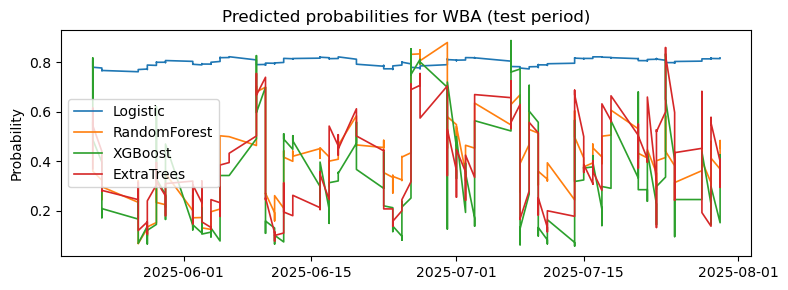

In [86]:

test_idx  = df_model["Date"] >  cutoff_date


# --- visualize variation within a single ticker for Logistic & RF ---
ticker_example = df_model.loc[test_idx, "Ticker"].value_counts().index[0]  # most frequent ticker
mask_t = (df_model.loc[test_idx, "Ticker"] == ticker_example).values

plt.figure(figsize=(8,3))
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         logit.predict_proba(X_test)[mask_t,1],
         label="Logistic", lw=1.2)
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         rf.predict_proba(X_test)[mask_t,1],
         label="RandomForest", lw=1.2)
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         xgb.predict_proba(X_test)[mask_t,1],
         label="XGBoost", lw=1.2)
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         extra.predict_proba(X_test)[mask_t,1],
         label="ExtraTrees", lw=1.2)
plt.title(f"Predicted probabilities for {ticker_example} (test period)")
plt.ylabel("Probability")
plt.legend(); plt.tight_layout(); plt.show()


In [82]:
probs = logit.predict_proba(X_test)[:,1]
uniq = np.unique(np.round(probs,6))
print("Unique probs:", len(uniq))
print("First 10:", uniq[:10])


Unique probs: 2069
First 10: [0.062005 0.064054 0.064124 0.064129 0.065662 0.066086 0.067937 0.068314
 0.077752 0.09259 ]


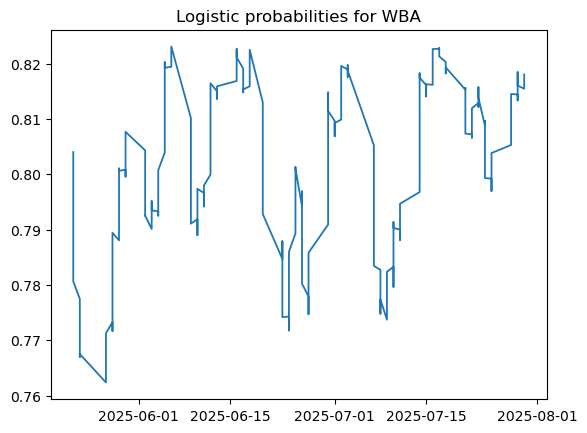

In [83]:
ticker_ex = df_model.loc[test_idx,"Ticker"].value_counts().index[0]
m = (df_model.loc[test_idx,"Ticker"]==ticker_ex).values
p = logit.predict_proba(X_test)[m,1]
plt.plot(df_model.loc[test_idx,"Date"].values[m], p, lw=1.3)
plt.title(f"Logistic probabilities for {ticker_ex}"); plt.show()
